In [1]:
import time, copy, torch, string, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer

from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch import nn, optim, cuda
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [2]:
# Note: the minimum number of articles for publication is 5214, and maximum is 11488
num_train = 800 # articles for each publication
num_valid = 100 # articles for each publication
num_test = 100 # articles for each publication

device = 0

In [3]:
max_sents = 50
max_words = 50

vocab_size = 20000
embed_size = 200

word_hidden_size = 100
sent_hidden_size = 100

num_classes = 15

dropout = 0.

In [4]:
def get_maps():    
    if not os.path.exists('Data/'):
        raise FileExistsError("Folder doesn't exist.")
    df_map = {}
    for csv_file in os.listdir('Data/'):
        if not csv_file.endswith('.gz'):
            continue
        pub = csv_file.split('.')[0]
        path = os.path.join('Data', csv_file)
        df_map[pub] = pd.read_csv(path, compression='gzip')
    
    labels_map = {}
    for l in open('Map/labels_map.txt'):
        k, v = l.strip().split(',')
        labels_map[k] = int(v)
    
    words_map = {}
    for l in open('Map/words_map.txt'):
        k, v = l.strip().split(',')
        if int(v) == vocab_size - 1:
            continue
        words_map[k] = int(v)
    
    return df_map, labels_map, words_map
df_map, labels_map, words_map = get_maps()

In [5]:
class AllTheNews(Dataset):
    def __init__(self, df_map, labels_map, words_map, start, end):

        self.df_map = df_map
        self.labels_map = labels_map
        self.words_map = words_map
        
        self.df = pd.DataFrame()
        
        for key, info in df_map.items():
            self.df = self.df.append(info.iloc[start:min(end, len(info))])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        article = torch.LongTensor(self.get_array(item['token']))
        label = torch.LongTensor([labels_map[item['publication']]])
        
        sample = (article, label)
        return sample
    
    def get_array(self, raw):
        return [[int(w) for w in s] for s in map(str.split, raw.strip('$ ').split('$ '))]

In [6]:
atn_train = AllTheNews(df_map, labels_map, words_map, 0, num_train)
atn_valid = AllTheNews(df_map, labels_map, words_map, num_train, num_train+num_valid)
atn_test = AllTheNews(df_map, labels_map, words_map, num_train+num_valid, num_train+num_valid+num_test)

In [7]:
batch_sizes = {x:1 for x in ['train', 'valid', 'test']}
num_examples = {'train':len(atn_train), 'valid':len(atn_valid), 'test':len(atn_test)}

In [8]:
train_data = DataLoader(
    dataset = atn_train,
    batch_size = batch_sizes['train'],
    shuffle = True,
    num_workers = 4,
)

valid_data = DataLoader(
    dataset = atn_valid,
    batch_size = batch_sizes['valid'],
    shuffle = True,
    num_workers = 4,
)

test_data = DataLoader(
    dataset = atn_test,
    batch_size = batch_sizes['test'],
    shuffle = True,
    num_workers = 4,
)

In [9]:
datasets = {
    'train':train_data,
    'valid':valid_data,
    'test':test_data,
}

In [10]:
cuda.set_device(device)
use_gpu = cuda.is_available()
print("GPU Availability = {c}".format(c=use_gpu))

GPU Availability = True


In [11]:
class WordAttnRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, word_hidden_size, dropout=0.0):
        super(WordAttnRNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.word_hidden_size = word_hidden_size
        self.dropout = dropout
        
        self.lookup = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, word_hidden_size, bidirectional=True)
        
        self.word_weights = nn.Parameter(torch.Tensor(2*word_hidden_size, 2*word_hidden_size))
        self.word_weights.data.uniform_(-0.1, 0.1)
        
        self.word_bias = nn.Parameter(torch.Tensor(2*word_hidden_size))
        self.word_bias.data.uniform_(-0.1, 0.1)
        
        self.context_weights = nn.Parameter(torch.Tensor(2*word_hidden_size, 1))
        self.context_weights.data.uniform_(-0.1, 0.1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        x_embed = self.lookup(x).view(x.size(1), batch_size, -1)
        # outputs dimension: T x B x 2H
        outputs, hidden = self.gru(x_embed, hidden)
        # tranpose to B x T x 2H
        outputs = outputs.transpose(0, 1)
        # h_representation dimension: B x T x 2H
        hidden_rp = torch.baddbmm(
            self.word_bias.expand(batch_size, seq_len, 2 * self.word_hidden_size), # B x T x 2H
            outputs, # B x T x 2H
            self.word_weights.expand(batch_size, 2 * self.word_hidden_size, 2 * self.word_hidden_size) # B x 2H x 2H
        )
        hidden_rp = F.tanh(hidden_rp)
        # attn_weights dimension B x T x 1
        attn_weights = torch.bmm(
            hidden_rp, # B x T x 2H
            self.context_weights.expand(batch_size, 2 * self.word_hidden_size, 1) # B x 2H x 1
        )
        # squeeze to B x T and do softmax
        attn_weights = F.softmax(attn_weights.squeeze(2))
        # unsqueeze attn_weights to B x T x 1, then perform element-wise mul with outputs
        # sum over sequence dimension to get y
        # s dimension B x 2H
        s = torch.sum(outputs * attn_weights.unsqueeze(2), dim=1)
        
        return s, hidden

    def initHidden(self, batch_size):
        if use_gpu:
            return Variable(torch.zeros(2, batch_size, self.word_hidden_size).cuda())
        else:
            return Variable(torch.zeros(2, batch_size, self.word_hidden_size))
    

In [12]:
class SentAttnRNN(nn.Module):
    def __init__(self, word_hidden_size, sent_hidden_size, num_classes, dropout=0.0):
        super(SentAttnRNN, self).__init__()
        
        self.word_hidden_size = word_hidden_size
        self.sent_hidden_size = sent_hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.gru = nn.GRU(2 * word_hidden_size, sent_hidden_size, bidirectional=True)
        
        self.sent_weights = nn.Parameter(torch.Tensor(2*sent_hidden_size, 2*sent_hidden_size))
        self.sent_weights.data.uniform_(-0.1, 0.1)
        
        self.sent_bias = nn.Parameter(torch.Tensor(2*sent_hidden_size))
        self.sent_bias.data.uniform_(-0.1, 0.1)
        
        self.context_weights = nn.Parameter(torch.Tensor(2*sent_hidden_size, 1))
        self.context_weights.data.uniform_(-0.1, 0.1)
        
        self.fc = nn.Linear(2*sent_hidden_size, num_classes)

    def forward(self, x, hidden):
        batch_size = B = x.size(1)
        seq_len = T = x.size(0)

        # outputs dimension: T x B x 2H
        outputs, hidden = self.gru(x, hidden)
        # tranpose to B x T x 2H
        outputs = outputs.transpose(0, 1)
        # h_representation dimension: B x T x 2H
        hidden_rp = torch.baddbmm(
            self.sent_bias.expand(B, T, 2 * self.sent_hidden_size), # B x T x 2H
            outputs, # B x T x 2H
            self.sent_weights.expand(B, 2 * self.sent_hidden_size, 2 * self.sent_hidden_size) # B x 2H x 2H
        )
        hidden_rp = F.tanh(hidden_rp)
        # attn_weights dimension B x T x 1
        attn_weights = torch.bmm(
            hidden_rp, # B x T x 2H
            self.context_weights.expand(B, 2 * self.sent_hidden_size, 1) # B x 2H x 1
        )
        # squeeze to B x T and do softmax
        attn_weights = F.softmax(attn_weights.squeeze(2))
        # unsqueeze attn_weights to B x T x 1, then perform element-wise mul with outputs
        # sum over sequence dimension to get y
        # v dimension B x 2H
        v = torch.sum(outputs * attn_weights.unsqueeze(2), dim=1)
        y = F.log_softmax(self.fc(v))
        
        return y, hidden

    def initHidden(self, batch_size):
        if use_gpu:
            return Variable(torch.zeros(2, batch_size, self.sent_hidden_size).cuda())
        else:
            return Variable(torch.zeros(2, batch_size, self.sent_hidden_size))
    

In [13]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embed_size, word_hidden_size, sent_hidden_size, num_classes, dropout=0.0):
        super(HAN, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.word_hidden_size = word_hidden_size
        self.sent_hidden_size = sent_hidden_size
        self.num_classes = num_classes
        
        self.wordAttnRNN = WordAttnRNN(vocab_size, embed_size, word_hidden_size)
        self.sentAttnRNN = SentAttnRNN(word_hidden_size, sent_hidden_size, num_classes)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        word_hidden, sent_hidden = hidden
        
        # calculate s
        s = Variable(torch.FloatTensor(max_sents, batch_size, 2 * self.word_hidden_size))
        if use_gpu:
            s = s.cuda()
        for i in range(max_sents):
            # s[i] is B x W
            _s, word_hidden = self.wordAttnRNN(x[:,i,:], word_hidden)
            s[i,:,:] = _s

        # calculate y
        y, sent_hidden = self.sentAttnRNN(s, sent_hidden)
        
        return y, (word_hidden, sent_hidden)
    
    def initHidden(self, batch_size):
        word_hidden = self.wordAttnRNN.initHidden(batch_size)
        sent_hidden = self.sentAttnRNN.initHidden(batch_size)
        return (word_hidden, sent_hidden)

In [14]:
han = HAN(vocab_size, embed_size, word_hidden_size, sent_hidden_size, num_classes)
if use_gpu:
    han = han.cuda()

In [15]:
if os.path.exists("han_model_0_100_100"):
    han.load_state_dict(torch.load("han_model_0_100_100"))

In [16]:
seq = Variable(torch.arange(0, 20000).unsqueeze(0).long().cuda())
res = han.wordAttnRNN.lookup(seq).squeeze()

In [17]:
res = res.data.cpu().numpy()

In [19]:
from sklearn.manifold import TSNE
res_drs = TSNE(n_components=2, verbose=True).fit_transform(res)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.208s...
[t-SNE] Computed neighbors for 20000 samples in 149.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

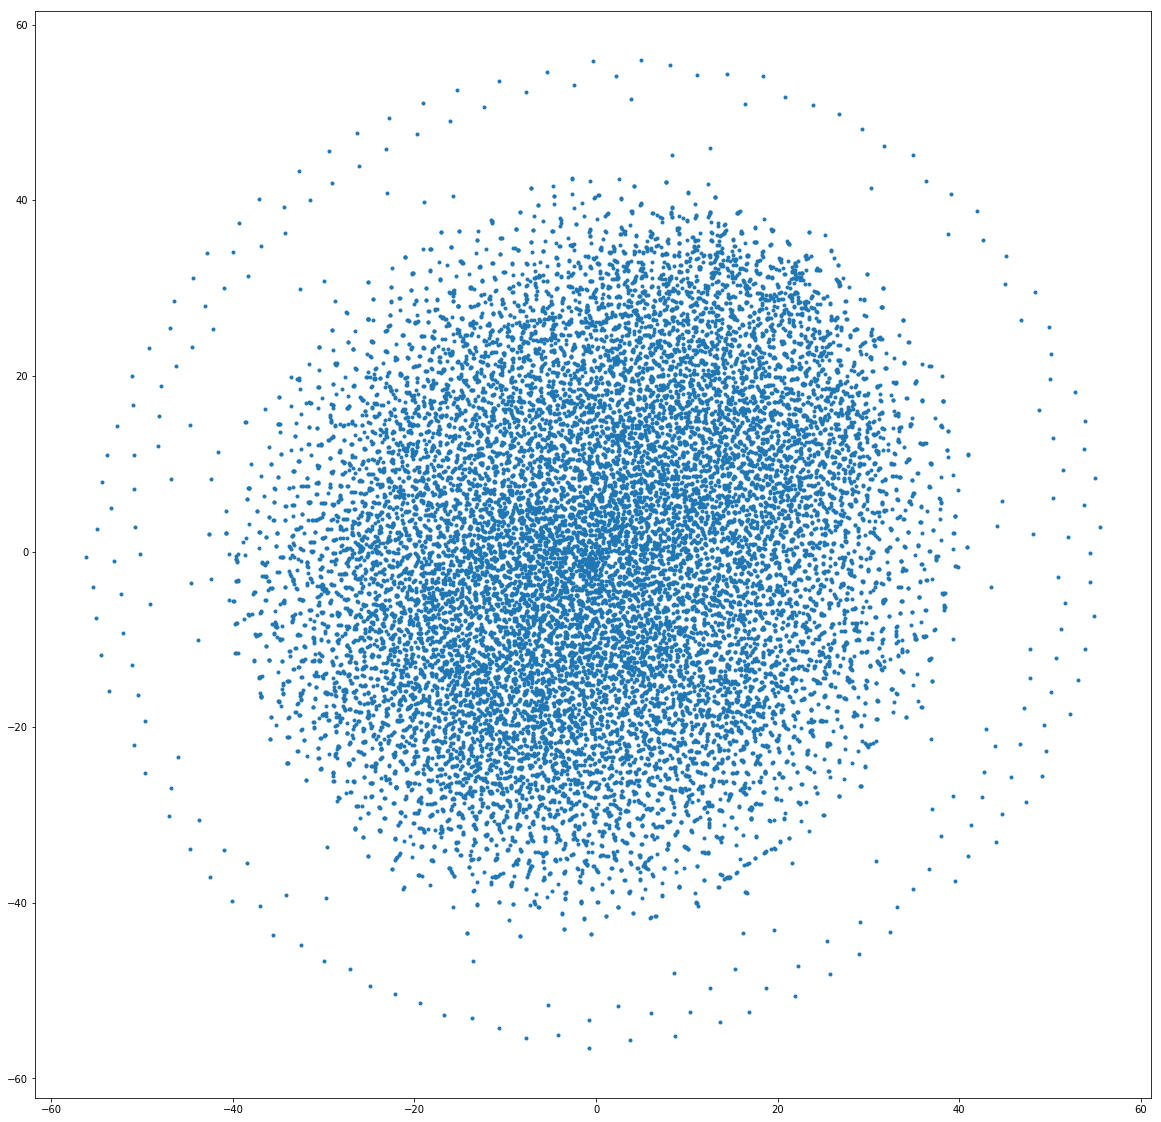

In [42]:
plt.figure(figsize=(20, 20))
plt.rcParams['axes.facecolor'] = 'white'
# plt.axis('off')
for x, y in res_drs:
    plt.plot(x, y, 'o')
plt.show()

In [41]:
from sklearn.decomposition import PCA
res_pca_drs = PCA(n_components=2).fit_transform(res)

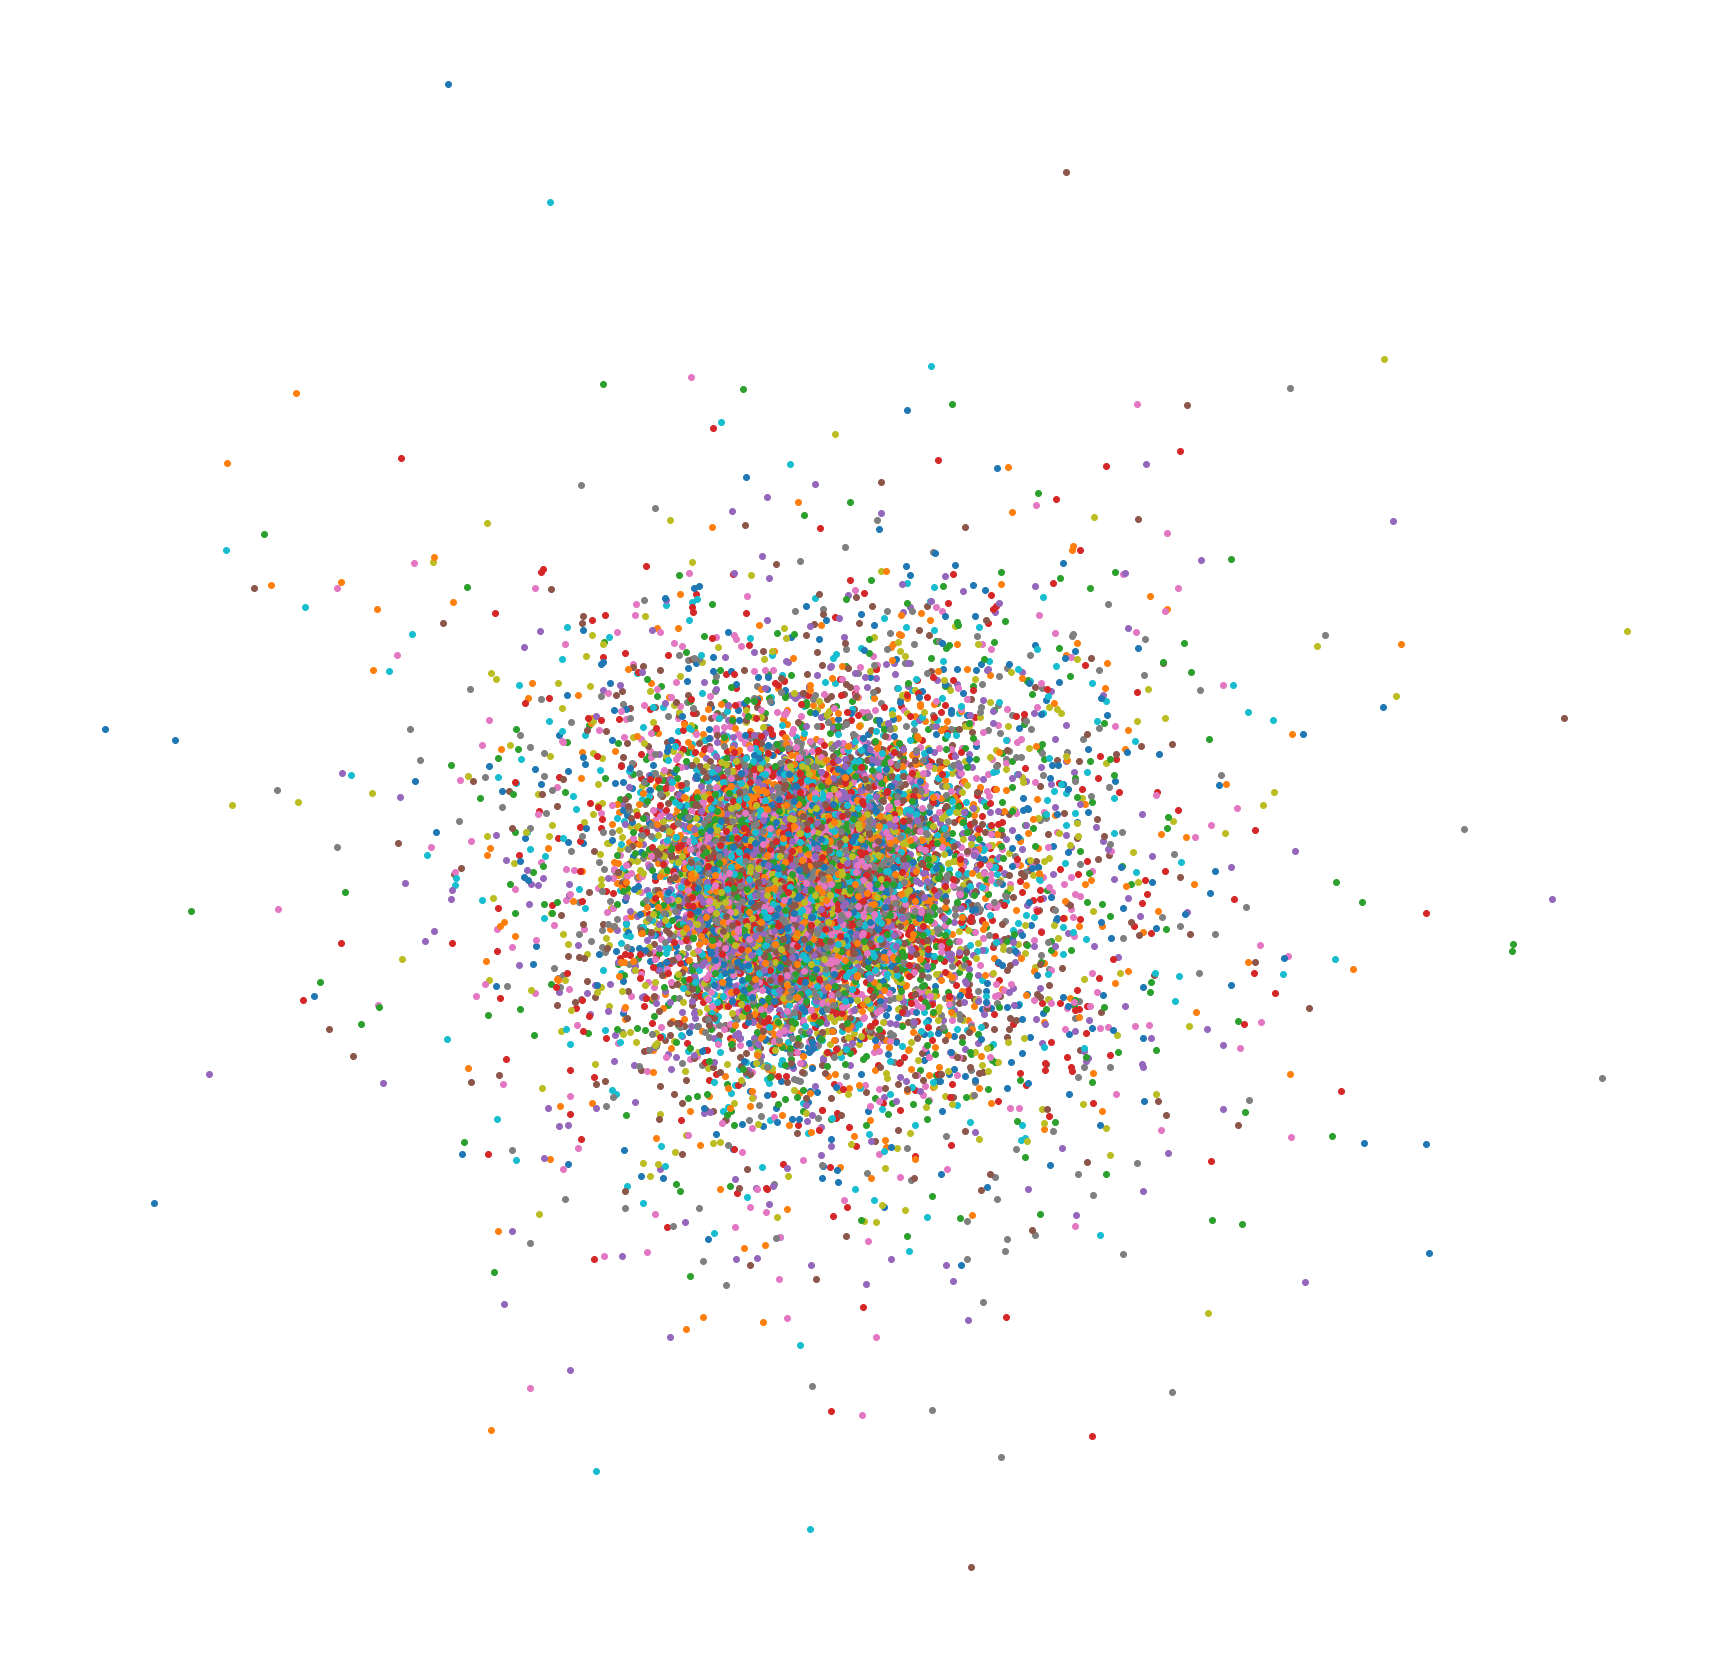

In [47]:
plt.figure(figsize=(20, 20))
# plt.axis('off')
for x, y in res_pca_drs:
    plt.plot(x, y, 'o')
plt.show()

In [15]:
def train_model(model, criterion, optimizer, num_epochs=25):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    loss_trace = {x:[] for x in ['train', 'valid', 'test']}
    acc_trace = {x:[] for x in ['train', 'valid', 'test']}
    
    f = open('epochs_info_han.txt', 'w')
    
    for epoch in tqdm_notebook(range(num_epochs), desc='Total'):
        f.write('Epoch {}/{}\n'.format(epoch + 1, num_epochs))
        f.write('-' * 10 + '\n')
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
                
        for phase in ['train', 'valid', 'test']:
            running_loss = 0.0
            running_corrects = 0.0
            
            for data in tqdm_notebook(datasets[phase], desc='{}th epoch:'.format(epoch+1), leave=False):
                inputs, labels = data
                labels = labels.long().view(-1)
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                hidden = model.initHidden(inputs.size(0))
                
                # zero the parameter gradients
                model.zero_grad()
                
                # forward
                outputs, hidden = model(inputs, hidden)
                _, preds = torch.max(outputs.data, 1)
                
#                 print(list(zip(preds.cpu().numpy(), labels.data.cpu().numpy())))
                
                loss = criterion(outputs, labels)
                if phase == 'train':
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                    
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / num_examples[phase]
            epoch_acc = running_corrects / num_examples[phase]
            
            f.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            loss_trace[phase].append(epoch_loss)
            acc_trace[phase].append(epoch_acc)
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                file_path = 'han_model_{}_{}_{}'.format(
                    int(dropout*10), word_hidden_size, sent_hidden_size)
                if os.path.exists(file_path):
                    os.unlink(file_path)
                torch.save(model.state_dict(), file_path)
                print("Model saved as {}".format(file_path))
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    f.close()
    return model, loss_trace, acc_trace

In [19]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(han.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
han, loss_trace, valid_trace = train_model(han, criterion, optimizer, num_epochs=25)

HBox(children=(IntProgress(value=0, description=u'Total', max=25), HTML(value=u'')))

Epoch 1/25
----------


HBox(children=(IntProgress(value=0, description=u'1th epoch:', max=12000), HTML(value=u'')))

/home/jiz722/anaconda2/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/jiz722/anaconda2/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 1.6606 Acc: 0.4594


HBox(children=(IntProgress(value=0, description=u'1th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.3429 Acc: 0.5767
Model saved as han_model_0_100_100


HBox(children=(IntProgress(value=0, description=u'1th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.3744 Acc: 0.5453
()
Epoch 2/25
----------


HBox(children=(IntProgress(value=0, description=u'2th epoch:', max=12000), HTML(value=u'')))

train Loss: 1.0656 Acc: 0.6608


HBox(children=(IntProgress(value=0, description=u'2th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.1591 Acc: 0.6487
Model saved as han_model_0_100_100


HBox(children=(IntProgress(value=0, description=u'2th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.1414 Acc: 0.6433
()
Epoch 3/25
----------


HBox(children=(IntProgress(value=0, description=u'3th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.7333 Acc: 0.7665


HBox(children=(IntProgress(value=0, description=u'3th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.1223 Acc: 0.6460


HBox(children=(IntProgress(value=0, description=u'3th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.1117 Acc: 0.6533
()
Epoch 4/25
----------


HBox(children=(IntProgress(value=0, description=u'4th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.4758 Acc: 0.8505


HBox(children=(IntProgress(value=0, description=u'4th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.2420 Acc: 0.6447


HBox(children=(IntProgress(value=0, description=u'4th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.3033 Acc: 0.6413
()
Epoch 5/25
----------


HBox(children=(IntProgress(value=0, description=u'5th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.3126 Acc: 0.9000


HBox(children=(IntProgress(value=0, description=u'5th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.3946 Acc: 0.6560
Model saved as han_model_0_100_100


HBox(children=(IntProgress(value=0, description=u'5th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.4000 Acc: 0.6640
()
Epoch 6/25
----------


HBox(children=(IntProgress(value=0, description=u'6th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2528 Acc: 0.9183


HBox(children=(IntProgress(value=0, description=u'6th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.4888 Acc: 0.6507


HBox(children=(IntProgress(value=0, description=u'6th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.4849 Acc: 0.6480
()
Epoch 7/25
----------


HBox(children=(IntProgress(value=0, description=u'7th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2417 Acc: 0.9220


HBox(children=(IntProgress(value=0, description=u'7th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.5583 Acc: 0.6367


HBox(children=(IntProgress(value=0, description=u'7th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.5362 Acc: 0.6433
()
Epoch 8/25
----------


HBox(children=(IntProgress(value=0, description=u'8th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2241 Acc: 0.9238


HBox(children=(IntProgress(value=0, description=u'8th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.6165 Acc: 0.6440


HBox(children=(IntProgress(value=0, description=u'8th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.6790 Acc: 0.6487
()
Epoch 9/25
----------


HBox(children=(IntProgress(value=0, description=u'9th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2142 Acc: 0.9283


HBox(children=(IntProgress(value=0, description=u'9th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.5423 Acc: 0.6540


HBox(children=(IntProgress(value=0, description=u'9th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.6020 Acc: 0.6233
()
Epoch 10/25
----------


HBox(children=(IntProgress(value=0, description=u'10th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2168 Acc: 0.9287


HBox(children=(IntProgress(value=0, description=u'10th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.6475 Acc: 0.6480


HBox(children=(IntProgress(value=0, description=u'10th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.6689 Acc: 0.6427
()
Epoch 11/25
----------


HBox(children=(IntProgress(value=0, description=u'11th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2123 Acc: 0.9323


HBox(children=(IntProgress(value=0, description=u'11th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.7177 Acc: 0.6553


HBox(children=(IntProgress(value=0, description=u'11th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.6751 Acc: 0.6567
()
Epoch 12/25
----------


HBox(children=(IntProgress(value=0, description=u'12th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.1902 Acc: 0.9386


HBox(children=(IntProgress(value=0, description=u'12th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8468 Acc: 0.6393


HBox(children=(IntProgress(value=0, description=u'12th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.9155 Acc: 0.6287
()
Epoch 13/25
----------


HBox(children=(IntProgress(value=0, description=u'13th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2032 Acc: 0.9319


HBox(children=(IntProgress(value=0, description=u'13th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.7038 Acc: 0.6593
Model saved as han_model_0_100_100


HBox(children=(IntProgress(value=0, description=u'13th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.8431 Acc: 0.6353
()
Epoch 14/25
----------


HBox(children=(IntProgress(value=0, description=u'14th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.1984 Acc: 0.9356


HBox(children=(IntProgress(value=0, description=u'14th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8068 Acc: 0.6533


HBox(children=(IntProgress(value=0, description=u'14th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.8957 Acc: 0.6387
()
Epoch 15/25
----------


HBox(children=(IntProgress(value=0, description=u'15th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2084 Acc: 0.9318


HBox(children=(IntProgress(value=0, description=u'15th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8762 Acc: 0.6313


HBox(children=(IntProgress(value=0, description=u'15th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.8783 Acc: 0.6273
()
Epoch 16/25
----------


HBox(children=(IntProgress(value=0, description=u'16th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2085 Acc: 0.9340


HBox(children=(IntProgress(value=0, description=u'16th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8532 Acc: 0.6360


HBox(children=(IntProgress(value=0, description=u'16th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.9348 Acc: 0.6260
()
Epoch 17/25
----------


HBox(children=(IntProgress(value=0, description=u'17th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2290 Acc: 0.9229


HBox(children=(IntProgress(value=0, description=u'17th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8408 Acc: 0.6467


HBox(children=(IntProgress(value=0, description=u'17th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.8665 Acc: 0.6327
()
Epoch 18/25
----------


HBox(children=(IntProgress(value=0, description=u'18th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2116 Acc: 0.9296


HBox(children=(IntProgress(value=0, description=u'18th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8059 Acc: 0.6400


HBox(children=(IntProgress(value=0, description=u'18th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.9879 Acc: 0.6307
()
Epoch 19/25
----------


HBox(children=(IntProgress(value=0, description=u'19th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2131 Acc: 0.9299


HBox(children=(IntProgress(value=0, description=u'19th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.7920 Acc: 0.6293


HBox(children=(IntProgress(value=0, description=u'19th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.9039 Acc: 0.6287
()
Epoch 20/25
----------


HBox(children=(IntProgress(value=0, description=u'20th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2071 Acc: 0.9331


HBox(children=(IntProgress(value=0, description=u'20th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.7785 Acc: 0.6440


HBox(children=(IntProgress(value=0, description=u'20th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.9301 Acc: 0.6360
()
Epoch 21/25
----------


HBox(children=(IntProgress(value=0, description=u'21th epoch:', max=12000), HTML(value=u'')))

train Loss: 0.2344 Acc: 0.9260


HBox(children=(IntProgress(value=0, description=u'21th epoch:', max=1500), HTML(value=u'')))

valid Loss: 1.8794 Acc: 0.6373


HBox(children=(IntProgress(value=0, description=u'21th epoch:', max=1500), HTML(value=u'')))

test Loss: 1.8873 Acc: 0.6193
()
Epoch 22/25
----------


HBox(children=(IntProgress(value=0, description=u'22th epoch:', max=12000), HTML(value=u'')))